In [3]:
import fitz
import pandas as pd
import os
import re
from collections import Counter

## Read Dataframe

In [4]:
def read_recommendation_clean(file_name):
    import nltk
    from nltk.util import bigrams, trigrams, ngrams
    # open document
    pdf_document = fitz.open(file_name)
    text = ''
    # extraction markers
    start_extraction = False
    end_extraction = False
    start_marker = "1 \nRecommendations"
    end_marker1 = "Why the committee made these recommendations"
    end_marker2 = "2 \nThe technology"
    page_marker = "© NICE 2023"
    
    # Loop through the pages and extract text between "1 Recommendation" and "2 The technology"
    for page_num in range(len(pdf_document)):
        page = pdf_document[page_num]
        page_text = page.get_text()
        title_text = page_text[:page_text.find(")",0) + 1]
        # Check for the start marker
        if start_marker in page_text and '1.1' in page_text:
            start_extraction = True
            # Remove text before the start marker
            page_text = page_text.split('1.1', 1)[-1]
        if start_extraction == False:
            continue
        # Check for the end marker
        if end_marker1 in page_text:
            # Remove text after the end marker
            page_text = page_text.split(end_marker1, 1)[0]
            # Stop extraction
            start_extraction = False
        elif end_marker2 in page_text:
            # Remove text after the end marker
            page_text = page_text.split(end_marker2, 1)[0]
            # Stop extraction
            start_extraction = False
        # remove the page footer"
        else:
            page_text = page_text.split(page_marker, 1)[0]
        #if title_text in page_text:
            #page_text = page_text.replace(title_text,'')
        page_text = re.sub(r'[^a-zA-Z -]', '', page_text)
        text += page_text
    return text

In [5]:
# Read Labelled Data from csv
lab_df = pd.read_csv('jnj_judgement.csv')
#lab_df.set_index(lab_df.columns[0], inplace=True)
train_df = lab_df[['title','JNJ Classification (manual)']].dropna()
train_df['Content'] = train_df['title'].apply(lambda f: read_recommendation_clean("./Files/" + f + "/" + f))

## Find Common Keywords

In [6]:
def extract_grams(df,num_gram):
    import nltk
    from nltk.util import ngrams
    # tokenize content and title
    tokenized_title = [word.lower() for text in df['title'].apply(lambda x: x.replace('-',' ')) for word in nltk.word_tokenize(text)]
    tokenized_content = [word.lower() for text in df['Content'] for word in nltk.word_tokenize(text)]
    
    # Create ngrams for both content and title
    content_grams = list(ngrams(tokenized_content, num_gram))
    title_grams = list(ngrams(tokenized_title,num_gram))

    # Find ngrams in tokenized_content but not in tokenized_title
    filtered_content_grams = [gram for gram in content_grams if gram not in title_grams]
    print(filtered_content_grams)
    # Find the top ngrams
    gram_counts = Counter(filtered_content_grams)
    return gram_counts

In [7]:
def extract_row_grams(row,title,content,num_gram):
    import nltk
    import numpy as np
    from nltk.util import ngrams
    # tokenize content and title
    tokenized_title = nltk.word_tokenize(row[title].lower().replace('-', ' '))
    tokenized_content = nltk.word_tokenize(row[content].lower().replace('-', ' '))
    # Create ngrams for both content and title
    content_grams = list(ngrams(tokenized_content, num_gram))
    title_grams = list(ngrams(tokenized_title,num_gram))

    # Find ngrams in tokenized_content but not in tokenized_title
    filtered_content_grams = [gram for gram in content_grams if gram not in title_grams]
    return list(set(filtered_content_grams))

In [8]:
def extract_grams(df,num_gram):
    df['ngrams'] = df.apply(extract_row_grams, args=('title', 'Content', num_gram), axis=1)
    gram_lst = []
    for r in df['ngrams']:
        for j in r:
            gram_lst.append(j)
    return Counter(gram_lst)

In [9]:
#def find_top_grams(gram_counts,num_top): 
    # Find the top ngrams
#    top_gram = gram_counts.most_common(num_top)
#    return top_gram

In [10]:
def combine_and_sum_dicts(dicts, whole_dict):
    #from collections import defaultdict
    # Create a dict to store the combined values
    combined_dict = {}    
    # Iterate through each dictionary
    for d in dicts:
        # Iterate through key-value pairs in the dictionary
        for key in d:
            # Add the value to the corresponding key in the combined dictionary
            combined_dict[key] = whole_dict[key]
    print(combined_dict)
    # Convert the defaultdict back to a regular dictionary
    return combined_dict

In [11]:
def find_unique_dict(o_dict, whole_dict):
    r_dict = {}
    # build dict with grams as key and (count in this category, count in others) as value
    for key, value in o_dict.items():
        r_dict[key] = (value, whole_dict[key]-value)
    # sort dict based on uniqueness and count
    sorted_dict = dict(
        sorted(r_dict.items(), key=lambda item: (item[1][1], -item[1][0])))
    return sorted_dict

In [12]:
def find_unique_grams(df,num_gram, num_top):
    # get the catergories of judgement
    cat = df['JNJ Classification (manual)'].value_counts().index.tolist()
    cat_lst = []
    for c in cat:
        # get most common k n-grams
        df_c = df[df['JNJ Classification (manual)'] == c]
        gram_cnt = extract_grams(df_c,num_gram)
        top_gram = gram_cnt.most_common(num_top)
        # transform into dict
        top_gram_dict = {t[0]:t[1] for t in top_gram}
        cat_lst.append(top_gram_dict)
    # get the number of occurances of grams in all categories
    combined_dict = dict(extract_grams(df,num_gram))
    # add uniqueness to gram_dict of each category
    cat_u_lst = []
    for d in cat_lst:
        u_dict = find_unique_dict(d, combined_dict)
        # put gram and the count together into list 
        u_lst = [(key, value) for key, value in u_dict.items()]
        cat_u_lst.append(u_lst)
    # build dataframe
    cat_dict = {key: value for key, value in zip(cat, cat_u_lst)}
    return pd.DataFrame(cat_dict)

In [13]:
find_unique_grams(train_df,5,10)

/var/folders/g4/f_rwknw54f999f7fy8ttscqh0000gn/T/ipykernel_68160/616014495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ngrams'] = df.apply(extract_row_grams, args=('title', 'Content', num_gram), axis=1)
/var/folders/g4/f_rwknw54f999f7fy8ttscqh0000gn/T/ipykernel_68160/616014495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ngrams'] = df.apply(extract_row_grams, args=('title', 'Content', num_gram), axis=1)
/var/folders/g4/f_rwknw54f999f7fy8ttscqh0000gn/T/ipykernel_68160/616014495.py:2: S

,Treatment Option,Not Supporting Routine Use,Routine Use
0,"((should, be, considered, as, an), (10, 0))","((not, enough, good, quality, evidence), (7, 0))","((by, an, average, of, per), (2, 0))"
1,"((be, considered, as, an, option), (9, 0))","((good, quality, evidence, to, support), (6, 0))","((person, this, cost, saving, assumes), (1, 0))"
2,"((is, recommended, as, an, option), (9, 0))","((is, not, enough, good, quality), (6, 0))","((for, adopting, gammacore, to, treat), (1, 0))"
3,"((considered, as, an, option, for), (8, 0))","((to, support, the, case, for), (14, 1))","((is, recommended, as, a, cost), (2, 4))"
4,"((as, an, option, for, people), (6, 0))","((support, the, case, for, routine), (13, 1))","((a, cost, saving, option, for), (2, 4))"
5,"((is, supported, by, the, evidence), (11, 1))","((the, case, for, routine, adoption), (13, 1))","((recommended, as, a, cost, saving), (2, 6))"
6,"((the, case, for, adopting, the), (11, 1))","((evidence, to, support, the, case), (11, 1))","((as, a, cost, saving, option), (2, 6))"
7,"((evidence, supports, the, case, for), (8, 2))","((is, recommended, to, address, uncertainties)...","((is, cost, saving, compared, with), (2, 7))"
8,"((supports, the, case, for, adopting), (8, 2))","((recommended, to, address, uncertainties, abo...","((evidence, supports, the, case, for), (2, 8))"
9,"((is, cost, saving, compared, with), (7, 2))","((routine, adoption, in, the, nhs), (7, 1))","((supports, the, case, for, adopting), (2, 8))"


## Feature Engineering

In [136]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

In [149]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(train_df[['Content','title']], train_df['JNJ Classification (manual)'], test_size=0.25, stratify=train_df['JNJ Classification (manual)'])

In [150]:
# Preprocessing
data = {'Content': X_train['Content'], 'title': X_train['title'],'JNJ Classification (manual)': y_train}
df = pd.DataFrame(data)
res = find_unique_grams(df,3,20)

/var/folders/g4/f_rwknw54f999f7fy8ttscqh0000gn/T/ipykernel_68160/616014495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ngrams'] = df.apply(extract_row_grams, args=('title', 'Content', num_gram), axis=1)
/var/folders/g4/f_rwknw54f999f7fy8ttscqh0000gn/T/ipykernel_68160/616014495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ngrams'] = df.apply(extract_row_grams, args=('title', 'Content', num_gram), axis=1)
/var/folders/g4/f_rwknw54f999f7fy8ttscqh0000gn/T/ipykernel_68160/616014495.py:2: S

In [151]:
# Feature Selection
top10 = res.iloc[:10]
top10 = top10.applymap(lambda x: list(x[0]))
top10 = top10.applymap(lambda x: ' '.join(x))
top10

/var/folders/g4/f_rwknw54f999f7fy8ttscqh0000gn/T/ipykernel_68160/1504102485.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  top10 = top10.applymap(lambda x: list(x[0]))
/var/folders/g4/f_rwknw54f999f7fy8ttscqh0000gn/T/ipykernel_68160/1504102485.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  top10 = top10.applymap(lambda x: ' '.join(x))


,Treatment Option,Not Supporting Routine Use,Routine Use
0,as an option,shows promise for,by an average
1,should be considered,is not enough,average of per
2,an option for,there is not,an average of
3,be considered as,not enough good,central catheters piccs
4,recommended as an,enough good quality,piccs with an
5,considered as an,good quality evidence,peripherally inserted central
6,for adopting the,to support the,medium to long
7,for people with,support the case,option for securing
8,is estimated to,case for routine,securing peripherally inserted
9,cost saving compared,for routine adoption,catheters piccs with


In [152]:
# get feature list
gram_list = top10.values.flatten().tolist()

In [153]:
# construct input data matrix
def contains_gram(content, gram):
    return int(gram in content)

X = train_df[['Content','title']]
y = train_df[['JNJ Classification (manual)']]
# Loop through each gram and apply the contains_gram function to create the new columns
for gram in gram_list:
    X[gram] = X['Content'].apply(contains_gram, gram=gram)
    X_train[gram] = X_train['Content'].apply(contains_gram, gram=gram)
    X_test[gram] = X_test['Content'].apply(contains_gram, gram=gram)
X_train = X_train.drop(['title','Content'],axis=1)
X_test = X_test.drop(['title','Content'],axis=1)
X = X.drop(['title','Content'],axis=1)

/var/folders/g4/f_rwknw54f999f7fy8ttscqh0000gn/T/ipykernel_68160/892397940.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[gram] = X['Content'].apply(contains_gram, gram=gram)


In [155]:
# Instantiate classifier
ovr = OneVsRestClassifier(SVC(kernel = "rbf", class_weight='balanced')).fit(X_train, y_train)

# Predict on train and test set
ovr_pred_train = ovr.predict(X_train)
ovr_pred_test = ovr.predict(X_test)

# Report accuracy
print("OVR Train Accuracy:", accuracy_score(y_train, ovr_pred_train))
print("OVR Test Accuracy:", accuracy_score(y_test, ovr_pred_test))

OVR Train Accuracy: 0.8541666666666666
OVR Test Accuracy: 0.9411764705882353


In [156]:
from sklearn.metrics import accuracy_score,classification_report
print(classification_report(y_test, ovr_pred_test))

                            precision    recall  f1-score   support

Not Supporting Routine Use       0.86      1.00      0.92         6
               Routine Use       0.00      0.00      0.00         1
          Treatment Option       1.00      1.00      1.00        10

                  accuracy                           0.94        17
                 macro avg       0.62      0.67      0.64        17
              weighted avg       0.89      0.94      0.91        17



/Users/tracy/opt/anaconda3/envs/coms4111/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tracy/opt/anaconda3/envs/coms4111/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tracy/opt/anaconda3/envs/coms4111/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [157]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, ovr_pred_test)

array([[ 6,  0,  0],
       [ 1,  0,  0],
       [ 0,  0, 10]])

<Figure size 400x400 with 0 Axes>

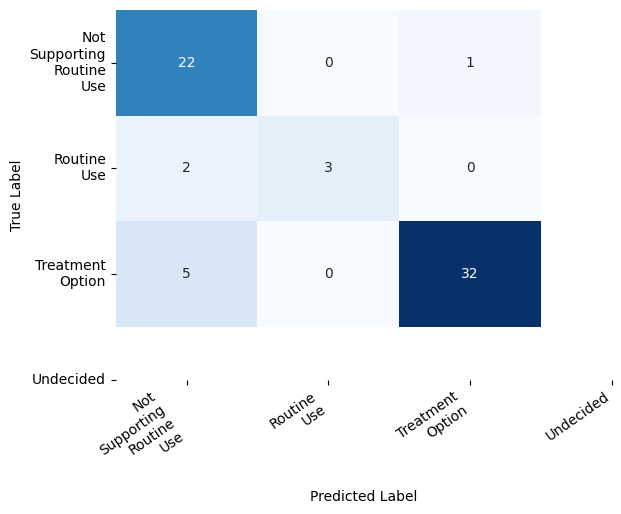

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import textwrap

cm = confusion_matrix(y, ovr.predict(X))

plt.figure(figsize=(4, 4))

x_labels = ['Not Supporting Routine Use', \
                         'Routine Use', \
                        'Treatment Option',\
                        'Undecided']

# Wrap x-axis labels
wrapped_labels = [textwrap.fill(label, width=10) for label in x_labels]
plt.show()

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=wrapped_labels, 
            yticklabels=wrapped_labels)

ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')


# Rotate y-axis labels
plt.yticks(rotation=0)


plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [160]:
print(classification_report(y, ovr.predict(X)))

                            precision    recall  f1-score   support

Not Supporting Routine Use       0.76      0.96      0.85        23
               Routine Use       1.00      0.60      0.75         5
          Treatment Option       0.97      0.86      0.91        37

                  accuracy                           0.88        65
                 macro avg       0.91      0.81      0.84        65
              weighted avg       0.90      0.88      0.88        65

